In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g29afe694f1+a272651890 	current w_2023_40 setup
alert_packet          g6041bd2d66 	current w_2023_40 setup
analysis_drp          g8a53795882+0c0064919b 	current w_2023_40 setup
analysis_tools        g01ff57b274+b4ae54b57f 	current w_2023_40 setup
ap_association        g9b2d7c2ad1+0898bae26d 	current w_2023_40 setup
ap_pipe               g9f065385ad+72c0e07383 	current w_2023_40 setup
ap_verify             g60239a501b+d279a3926c 	current w_2023_40 setup
astro_metadata_translator g0978aabd1f+0ffa813159 	current w_2023_40 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_40 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_40 setup
cbp                   ga32fcf49c8+650be1a39c 	current w_2023_40 setup
cell_coadds           g9faf7ed3f3+0c0064919b 	current w_2023_40 setup
coadd_utils           g337abbeb29+650be1a39c 	current w_2023_40 setup
cp_pipe         

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

We check the different dimension records existing for *physical_filter*: 

In [10]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [11]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [12]:
obs_type = 'science'
obs_day = 20230927
physical_filter = 'empty~holo4_003' 
science_program = 'BLOCK-102'

In [13]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'exp_time','ra','dec','skyangle','science_program'])

In [14]:

where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}' AND exposure.science_program='{3}'".format(obs_type,obs_day,physical_filter,science_program)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023092700216
  physical_filter: 'empty~holo4_003'
  obs_id: 'AT_O_20230927_000216'
  exposure_time: 10.0
  dark_time: 10.2349
  observation_type: 'science'
  observation_reason: 'sitcom-1043'
  day_obs: 20230927
  seq_num: 216
  seq_start: 216
  seq_end: 216
  group_name: '2023-09-28T00:15:34.874'
  group_id: 2757897348740000
  target_name: 'HD200654'
  science_program: 'BLOCK-102'
  tracking_ra: 316.6491969794358
  tracking_dec: -49.959909072308356
  sky_angle: 50.46512696949269
  azimuth: 151.73508064908015
  zenith_angle: 23.407030934054532
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-28 00:17:54.366009', scale='tai', format='iso'), end=astropy.time.Time('2023-09-28 00:18:04.601000', scale='tai', format='iso'))
	 timespan:             [2023-09-28T00:17:54.366009, 2023-09-28T00:18:04.601000)
	 timespan.begin:       2023-09-28 00:17:54.366009
	 id:                   2023092700216
	 day_obs:              20230927

In [15]:
print('Number of entries = ',len(df_science))

Number of entries =  31


In [16]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,exp_time,ra,dec,skyangle,science_program
26,2023092700242,AT_O_20230927_000242,20230927,242,2023-09-28 00:32:51.187015,2023-09-28 00:33:01.419,science,HD200654,empty~holo4_003,21.999627,10.0,316.647530,-49.960795,50.464784,BLOCK-102
27,2023092700243,AT_O_20230927_000243,20230927,243,2023-09-28 00:33:24.729018,2023-09-28 00:33:34.970,science,HD200654,empty~holo4_003,21.952772,10.0,316.649214,-49.959914,50.464968,BLOCK-102
28,2023092700244,AT_O_20230927_000244,20230927,244,2023-09-28 00:33:58.220005,2023-09-28 00:34:08.460,science,HD200654,empty~holo4_003,21.904850,10.0,316.650800,-49.959021,50.464990,BLOCK-102
29,2023092700245,AT_O_20230927_000245,20230927,245,2023-09-28 00:34:31.724993,2023-09-28 00:34:41.959,science,HD200654,empty~holo4_003,21.858781,10.0,316.652491,-49.958164,50.465024,BLOCK-102
30,2023092700246,AT_O_20230927_000246,20230927,246,2023-09-28 00:35:05.134991,2023-09-28 00:35:15.368,science,HD200654,empty~holo4_003,21.811665,10.0,316.654197,-49.957241,50.464846,BLOCK-102


Select exposures: 

In [17]:
seq_nums = np.sort(np.array(df_science.seq_num))
print(seq_nums)

[216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246]


In [18]:
ids = np.sort(np.array(df_science.id))
print(ids)

[2023092700216 2023092700217 2023092700218 2023092700219 2023092700220
 2023092700221 2023092700222 2023092700223 2023092700224 2023092700225
 2023092700226 2023092700227 2023092700228 2023092700229 2023092700230
 2023092700231 2023092700232 2023092700233 2023092700234 2023092700235
 2023092700236 2023092700237 2023092700238 2023092700239 2023092700240
 2023092700241 2023092700242 2023092700243 2023092700244 2023092700245
 2023092700246]


In [19]:
seq_nums = np.sort(np.array(df_science.seq_num))
ids = np.sort(np.array(df_science.id))

In [20]:
print(len(seq_nums))

31


We select an exposure that we know it was taken at the nominal position 

In [21]:
nom_seq = 216
seq_num0 = seq_nums[seq_nums==nom_seq][0]
exp_id0 = ids[seq_nums==nom_seq][0]
print(exp_id0)

2023092700216


In [22]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

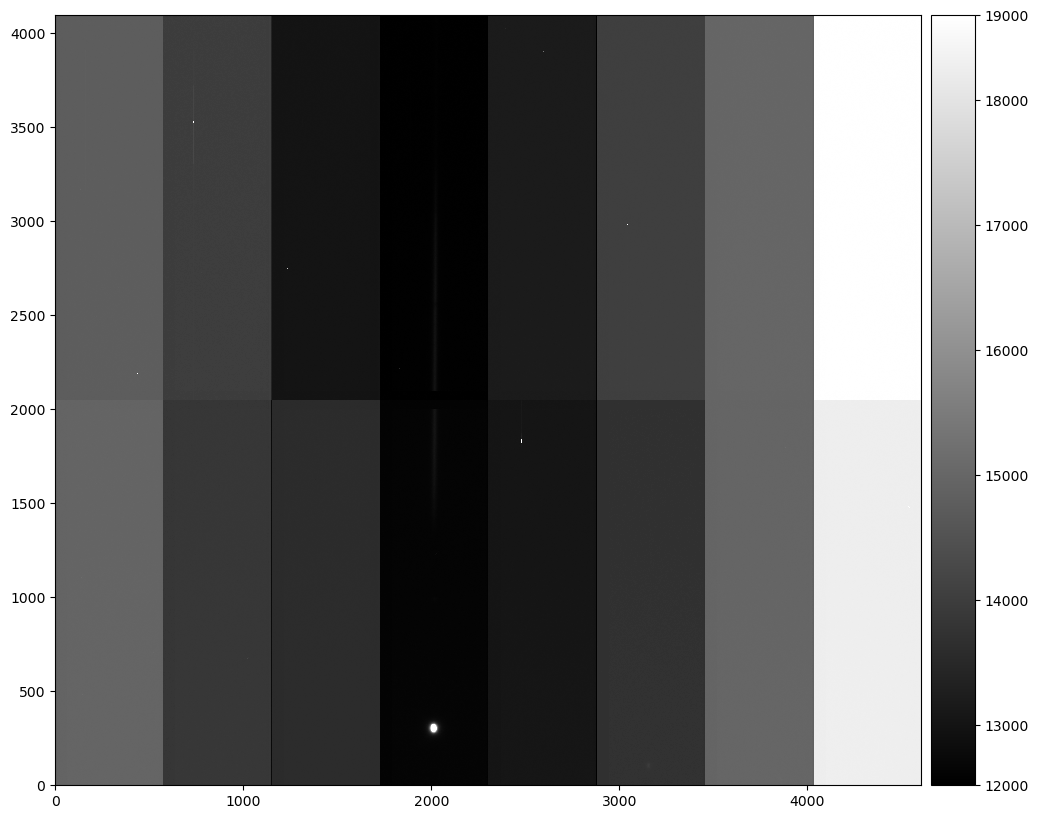

In [23]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

## Organize amplifiers 

In [24]:
ampli_boxes = {}
ampli_names = []
for ampIdx, amp in enumerate(test_img.getDetector()):
    ampli_name_ = amp.getName()
    ampli_names.append(ampli_name_)
    xbegin = amp.getBBox().x.begin
    xend = amp.getBBox().x.end
    ybegin = amp.getBBox().y.begin
    yend = amp.getBBox().y.end
    ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)

In [25]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [26]:
# configuration
isr_config =  IsrTaskConfig()

In [27]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [28]:
isr_task = IsrTask(config=isr_config)

In [29]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [30]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


In [31]:
test_ = isr_test.exposure.image.array

Value range 

In [32]:
np.min(test_.flatten())

-81.59098

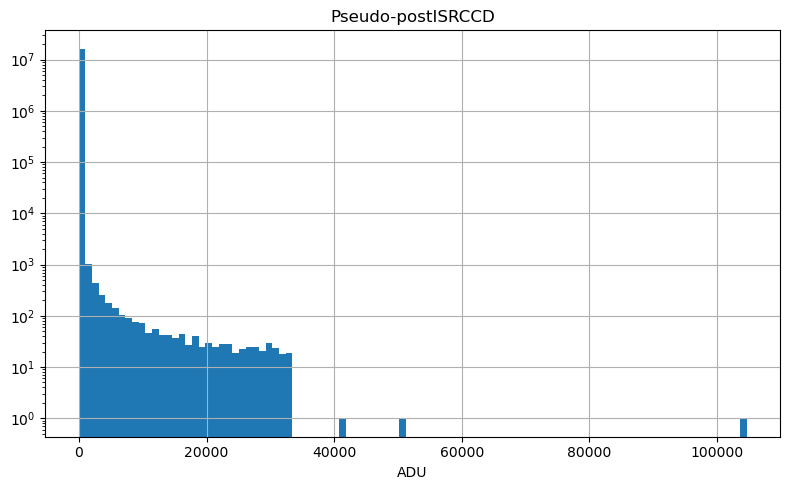

In [33]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Pseudo-postISRCCD')
plt.tight_layout()

In [34]:
nom_y = 290

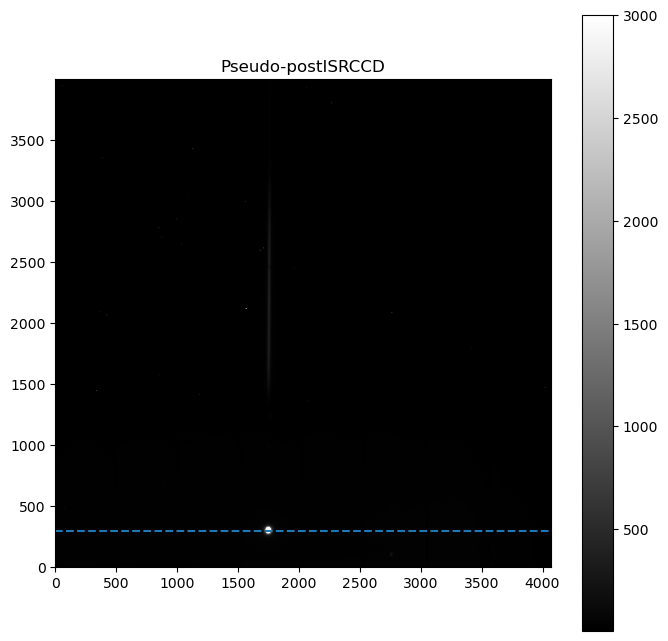

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(test_,cmap="gray",origin='lower',vmin=5,vmax=3000)
ax.axhline(y=nom_y,ls='--')
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

In [36]:

img_dict = {}
for i,id_ in enumerate(ids):
    print(id_)
    
    raw_ = butler.get('raw', dataId={'exposure': id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    bias_ = butler.get("bias",instrument=cameraName, exposure= id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    isr_ = isr_task.run(raw_,bias=bias_,defects=defects_)
    img_ = isr_.exposure.image.array
    
    img_dict[id_] = img_
    
    del(raw_)
    del(bias_)
    del(defects_)
    del(isr_)
    del(img_)
    

2023092700216


2023092700217


2023092700218


2023092700219


2023092700220


2023092700221


2023092700222


2023092700223


2023092700224


2023092700225


2023092700226


2023092700227


2023092700228


2023092700229


2023092700230


2023092700231


2023092700232


2023092700233


2023092700234


2023092700235


2023092700236


2023092700237


2023092700238


2023092700239


2023092700240


2023092700241


2023092700242


2023092700243


2023092700244


2023092700245


2023092700246


In [40]:
ampli0 = 'C03'
print(ampli_boxes[ampli0])
x0 = ampli_boxes[ampli0][0]
x1 = ampli_boxes[ampli0][1]
y0 = ampli_boxes[ampli0][2]
y1 = ampli_boxes[ampli0][3]

(1527, 2036, 0, 2000)


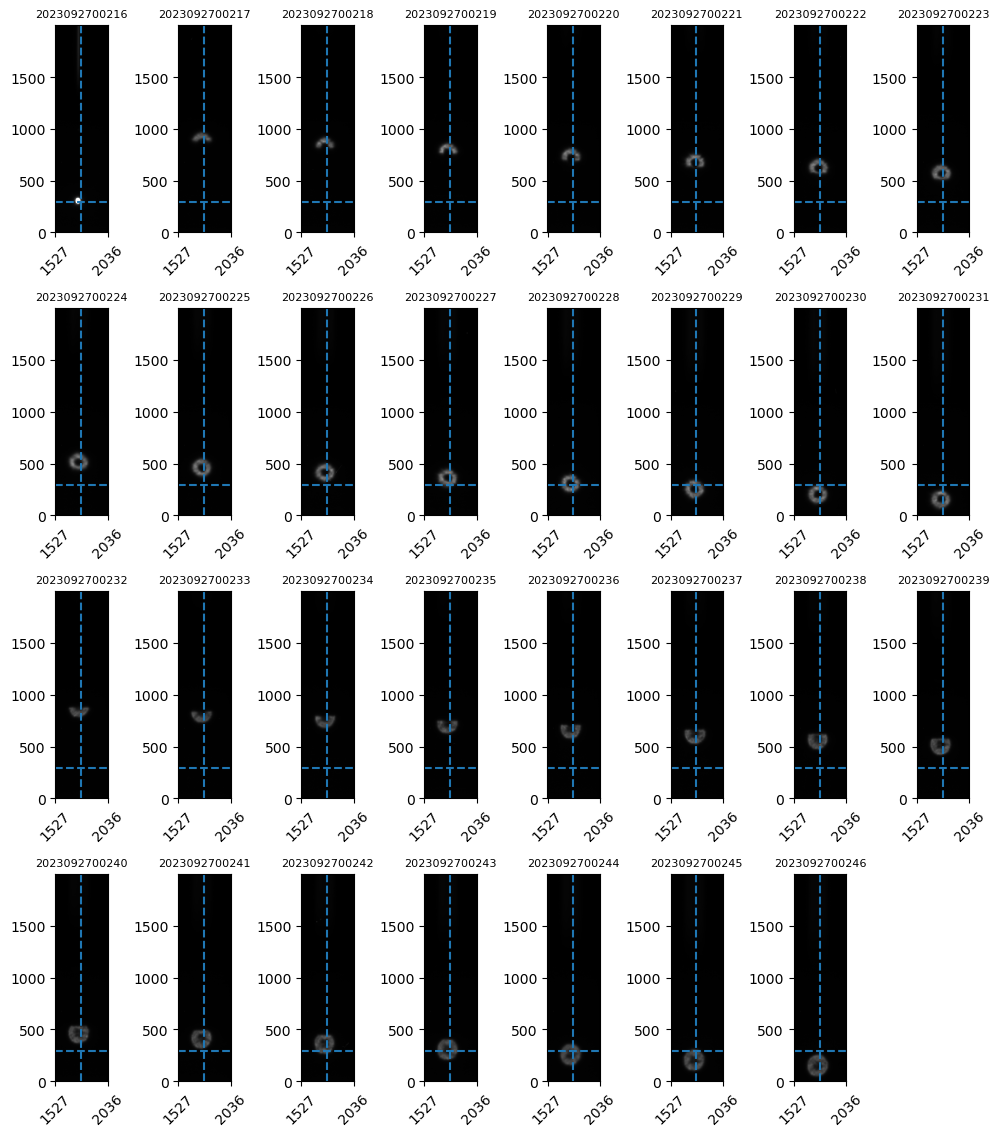

In [41]:
fig = plt.figure(figsize=(10,28))

num_cols = 8
num_rows = int(len(ids)/num_cols)+int(len(ids)%num_cols)

img_list = []
for i,id_ in enumerate(ids):
    img_ = img_dict[id_]
    
    ax = fig.add_subplot(num_rows,num_cols,i+1)
    #im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
    im = ax.imshow(img_[y0:y1,x0:x1],cmap="gray",origin='lower',vmin=5,vmax=3000)
    
    xticks = np.array([0,x1-x0])
    xticks_label = np.array([x0,x1])
    ax.set_xticks(xticks,labels=xticks_label,rotation=45)
    
    ax.axvline(x=1750-1500,ls='--')
    ax.axhline(y=290,ls='--')
    
    ax.set_title(id_,fontsize=8)

plt.tight_layout()